In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import validation_curve

In [2]:
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test_bqCt9Pv.csv')
df = df1.append(df2)

In [3]:
df = df.dropna(subset = ['loan_default','Employment.Type']) 

df['Employment.Type'] = np.where(df['Employment.Type']=='Self employed', 1, 0).astype(int)
df.rename(columns={'Employment.Type':'Self.Employed'})

df[['Date.of.Birth', 'DisbursalDate']] = df[['Date.of.Birth', 'DisbursalDate']].apply(pd.to_datetime)

df[['CREDIT.HISTORY.YR', 'CREDIT.HISTORY.MON']] = df['CREDIT.HISTORY.LENGTH'].str.extractall('(\d+)').unstack().astype(int)
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.YR']+(df['CREDIT.HISTORY.MON']/12)
df[['AVERAGE.ACCT.YR', 'AVERAGE.ACCT.MON']] = df['AVERAGE.ACCT.AGE'].str.extractall('(\d+)').unstack().astype(int)
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.YR']+(df['AVERAGE.ACCT.MON']/12)
df = df.drop(columns = ['CREDIT.HISTORY.YR','CREDIT.HISTORY.MON','AVERAGE.ACCT.YR','AVERAGE.ACCT.MON'])

df = df.drop(columns = ['UniqueID','branch_id','supplier_id','manufacturer_id','Current_pincode_ID','PERFORM_CNS.SCORE.DESCRIPTION'])
# id numbers will not be helpful

In [4]:
for x in df.columns:
    print (x,",", df[x].isnull().sum())

disbursed_amount , 0
asset_cost , 0
ltv , 0
Date.of.Birth , 0
Employment.Type , 0
DisbursalDate , 0
State_ID , 0
Employee_code_ID , 0
MobileNo_Avl_Flag , 0
Aadhar_flag , 0
PAN_flag , 0
VoterID_flag , 0
Driving_flag , 0
Passport_flag , 0
PERFORM_CNS.SCORE , 0
PRI.NO.OF.ACCTS , 0
PRI.ACTIVE.ACCTS , 0
PRI.OVERDUE.ACCTS , 0
PRI.CURRENT.BALANCE , 0
PRI.SANCTIONED.AMOUNT , 0
PRI.DISBURSED.AMOUNT , 0
SEC.NO.OF.ACCTS , 0
SEC.ACTIVE.ACCTS , 0
SEC.OVERDUE.ACCTS , 0
SEC.CURRENT.BALANCE , 0
SEC.SANCTIONED.AMOUNT , 0
SEC.DISBURSED.AMOUNT , 0
PRIMARY.INSTAL.AMT , 0
SEC.INSTAL.AMT , 0
NEW.ACCTS.IN.LAST.SIX.MONTHS , 0
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS , 0
AVERAGE.ACCT.AGE , 0
CREDIT.HISTORY.LENGTH , 0
NO.OF_INQUIRIES , 0
loan_default , 0


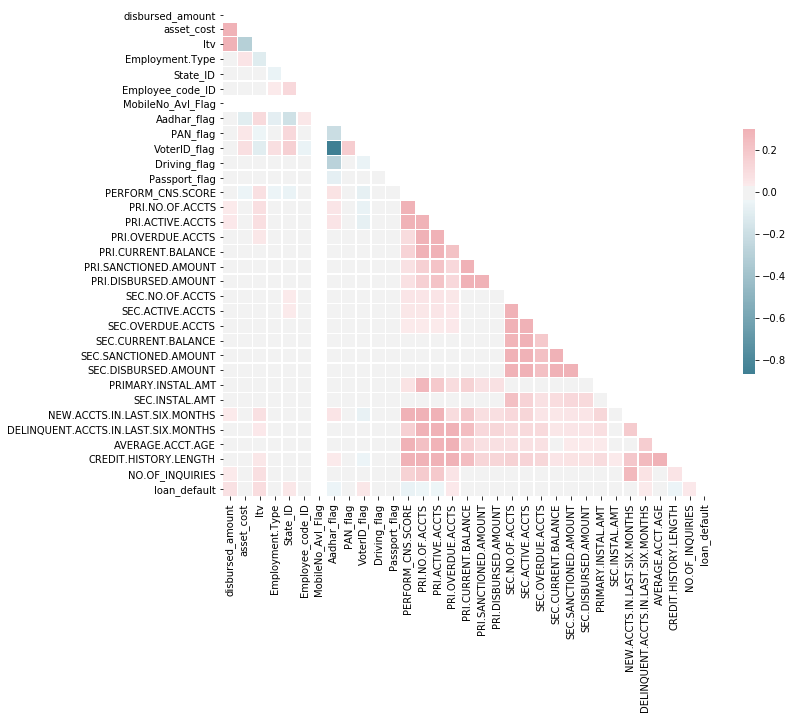

In [5]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
corr = df.corr(method = 'pearson')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

/Users/jenniferzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


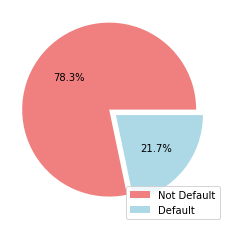

In [6]:
f, ax = plt.subplots()
ax.pie(df['loan_default'].value_counts(), labels=None, explode=(0.1,0), 
       autopct='%1.1f%%', colors=['lightcoral','lightblue'])
L = ['Not Default', 'Default']
ax.legend(L, loc='lower right')
f.show()

In [7]:
X = df.drop(columns = ['loan_default'])
y = df['loan_default']

scaler = StandardScaler()

for col in X.columns:
    X[[col]] = scaler.fit_transform(X[[col]])
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Logistic Regression

In [8]:
clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
np.mean(y_pred == y_test)

0.7808213103122044

# Elastic Net Logistic Regression

In [9]:
#Normalizing data
sc = StandardScaler()
X_train_n = sc.fit_transform(X_train)
X_train_n = pd.DataFrame(X_train_n)
X_test_n = sc.transform(X_test)
X_test_n = pd.DataFrame(X_test_n)

In [ ]:
#Using Grid Search CV to tune ratio and lambda paramaters
EN = SGDClassifier(loss='log', penalty='elasticnet')
parametersGrid = {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}
EN = SGDClassifier(loss='log', penalty = 'elasticnet', max_iter=10000)
grid = GridSearchCV(EN, parametersGrid, scoring='accuracy', cv=10)


grid.fit(X_train_n, y_train)


In [ ]:
en_cv_scores = cross_val_score(grid, X_train, y_train, cv=5)
en_cv_scores

In [ ]:
#Training Errors
y_pred_train = grid.predict(X_train_n)
#Testing Errors
y_pred_test = grid.predict(X_test_n)

print("Train accuracy is ", np.mean(y_pred_train == y_train))
print("Test accuracy is ", np.mean(y_pred_test == y_test))


In [ ]:
grid

Lambda for elastic net is 0.001, L1 ratio is 0.15

In [ ]:
metrics.plot_roc_curve(grid, X_test_n, y_test)


In [ ]:

psi = grid.best_estimator_.coef_.reshape(-1, 1)
print(len(psi[psi==0]), " of the ", X_train.shape[1], " variables were sent to 0.")
psi

LTV is only variable not set to 0

# Lasso


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lasso = Lasso(alpha=0.5)
lasso.fit(X_train, y_train) 

y_pred = lasso.predict(X_test)
print('Lasso Regression: R^2 score on test set', lasso.score(X_test, y_test)*100)

In [ ]:
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]


coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

for ind, i in enumerate(lambdas):    
    lasso = Lasso(alpha = i)
    lasso.fit(X_train, y_train)

    coeff_a[ind,:] = lasso.coef_
    train_r_squared[ind] = lasso.score(X_train, y_train)
    test_r_squared[ind] = lasso.score(X_test, y_test)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

In [ ]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
df_lam.loc[df_lam['R_squared'].idxmax()]

In [ ]:
lasso_best = Lasso(alpha = 0.001)
lasso_best.fit(X_train, y_train)
lasso_best.coef_

mean_squared_error(y_test, lasso_best.predict(X_test))

In [ ]:
l_min = 0.0005
l_max = 0.2
l_num = 20
lambdas = np.linspace(l_min,l_max, l_num)

train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

pred_num = X.shape[1]
coeff_a = np.zeros((l_num, pred_num))

for ind, i in enumerate(lambdas):    
    lasso = Lasso(alpha = i)
    lasso.fit(X_train, y_train)
    results = cross_val_score(lasso, X, y, cv=5, scoring="r2")

    train_r_squared[ind] = lasso.score(X_train, y_train)    
    test_r_squared[ind] = lasso.score(X_test, y_test)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda value'); plt.ylabel(r'$R^2$')
plt.xlim(0, 19)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

In [ ]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
df_lam.loc[df_lam['R_squared'].idxmax()]

In [ ]:
# best model
lasso_best = Lasso(alpha = 0.0005)
lasso_best.fit(X_train, y_train)
print('Mean Squared Error:', mean_squared_error(y_test, lasso_best.predict(X_test)))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, lasso_best.predict(X_test))))

In [ ]:
cross_val_score(Lasso(), X_train, y_train, scoring="neg_mean_squared_error", cv = 5)

In [ ]:
from sklearn.linear_model import LassoCV
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
rmse_cv(model_lasso).mean()

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
coef.head()

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

# Ridge

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train) 

y_pred = ridge.predict(X_test)
print('Ridge Regression: R^2 score on test set', ridge.score(X_test, y_test)*100)

In [ ]:
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)
for ind, i in enumerate(lambdas):    
    ridge = Ridge(alpha = i)
    ridge.fit(X_train, y_train)

    coeff_a[ind,:] = ridge.coef_
    train_r_squared[ind] = ridge.score(X_train, y_train)
    test_r_squared[ind] = ridge.score(X_test, y_test)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate ridge regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

In [ ]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
df_lam.loc[df_lam['R_squared'].idxmax()]

In [ ]:
ridge_best = Ridge(alpha = 0.001)
ridge_best.fit(X_train, y_train)
ridge_best.coef_

mean_squared_error(y_test, ridge_best.predict(X_test))

In [ ]:
l_min = 0.0005
l_max = 0.2
l_num = 20
lambdas = np.linspace(l_min,l_max, l_num)

train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

pred_num = X.shape[1]
coeff_a = np.zeros((l_num, pred_num))

for ind, i in enumerate(lambdas):    
    ridge = Ridge(alpha = i)
    ridge.fit(X_train, y_train)
    results = cross_val_score(ridge, X, y, cv=5, scoring="r2")

    train_r_squared[ind] = ridge.score(X_train, y_train)    
    test_r_squared[ind] = ridge.score(X_test, y_test)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda value'); plt.ylabel(r'$R^2$')
plt.xlim(0, 19)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

In [ ]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
df_lam.loc[df_lam['R_squared'].idxmax()]

In [ ]:
# best model
ridge_best = Ridge(alpha = 0.0005)
ridge_best.fit(X_train, y_train)
print('Mean Squared Error:', mean_squared_error(y_test, ridge_best.predict(X_test)))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, ridge_best.predict(X_test))))

In [ ]:
cross_val_score(Ridge(), X_train, y_train, scoring="neg_mean_squared_error", cv = 5)

In [ ]:
alphas = [0.0005, 0.001, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50]
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [ ]:
cv_ridge.min()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

In [ ]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Accuracy:', rfc.score(X_test,y_test))

In [ ]:
preds = np.stack([t.predict(X_test) for t in rfc.estimators_])
preds[:,0], np.mean(preds[:,0])
plt.plot([r2_score(y_test, np.mean(preds[:i+1], axis=0)) for i in range(10)])
plt.xlabel('n_estimators'); plt.ylabel(r'$R^2$')
plt.show()

In [ ]:
importances = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(rfc.feature_importances_,3)})
importances = importances.sort_values('Importance',ascending=False).set_index('Feature')

print(importances)
importances.plot.bar()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
plt.plot(*roc_curve(y_test, rfc.predict_proba(X_test)[:,1])[:2])
plt.plot(*roc_curve(y_test, rfc.predict(X_test))[:2])
plt.show()

# SVM

In [ ]:
#Linear
sv = svm.SVC(kernel = 'linear', C=1)

sv.fit(X_train, y_train)

#Cross Validation
svm_cv_scores = cross_val_score(sv, X_train, y_train, cv=5)
svm_cv_scores

In [ ]:
y_pred = sv.predict(X_test)
np.mean(y_pred == y_test)

In [ ]:
#Polynomial
svp = svm.SVC(kernel = 'poly', C=1)

svp.fit(X_train, y_train)

#Cross Validation
svmp_cv_scores = cross_val_score(svp, X_train, y_train, cv=5)
svmp_cv_scores

In [ ]:
#Testing accuracy
y_predp_test = svp.predict(X_test)
#Training accuracy
y_predp_train = svp.predict(X_train)


In [ ]:
print("Testing accuracy is", np.mean(y_predp_test == y_test))
print("Training accuracy is", np.mean(y_predp_train == y_train))


In [ ]:
metrics.plot_roc_curve(svp, X_test_n, y_test)

# PCA

In [ ]:
pca = PCA()
pca_model = pca.fit(X_train_n)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 35, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 35, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

Bootstrapping PCA

In [ ]:
#Resampling
X1 = X_train_n.sample(frac=1, replace=True)
X2 = X_train_n.sample(frac=1, replace=True)
X3 = X_train_n.sample(frac=1, replace=True)
X4 = X_train_n.sample(frac=1, replace=True)
X5 = X_train_n.sample(frac=1, replace=True)

In [ ]:
#Calculating variance for each sample
pca = PCA()
pca_model = pca.fit(X1)
x1 = np.arange(1, 35, step=1)
y1 = np.cumsum(pca.explained_variance_ratio_)

pca = PCA()
pca_model = pca.fit(X2)
x2 = np.arange(1, 35, step=1)
y2 = np.cumsum(pca.explained_variance_ratio_)

pca = PCA()
pca_model = pca.fit(X3)
x3 = np.arange(1, 35, step=1)
y3 = np.cumsum(pca.explained_variance_ratio_)

pca = PCA()
pca_model = pca.fit(X4)
x4 = np.arange(1, 35, step=1)
y4 = np.cumsum(pca.explained_variance_ratio_)

pca = PCA()
pca_model = pca.fit(X5)
x5 = np.arange(1, 35, step=1)
y5 = np.cumsum(pca.explained_variance_ratio_)

#plt.ylim(0.0,1.1)
#plt.plot(xi, y, marker='o', linestyle='--', color='b')

#plt.xlabel('Number of Components')
#plt.xticks(np.arange(0, 35, step=1)) #change from 0-based array index to 1-based human-readable label
#plt.ylabel('Cumulative variance (%)')
#plt.title('The number of components needed to explain variance')

#plt.axhline(y=0.95, color='r', linestyle='-')
#plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

#ax.grid(axis='x')
#plt.show()

In [ ]:
#Averaging variance across samples
y_boot = np.concatenate((y1.reshape(1,34), y2.reshape(1,34),y3.reshape(1,34), y4.reshape(1,34), y5.reshape(1,34)), axis=0)
y_boot_mean = y_boot.mean(axis=0)


In [ ]:
#Plotting variance
fig, ax = plt.subplots()
xi = np.arange(1, 35, step=1)
y = y_boot_mean

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 35, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance, bootstrapped')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()